In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

%matplotlib inline

In [2]:
cwd = os.getcwd()
cwd

'/Users/ebrembilla/Scripts/GitHub/MEGA-ClimateAdaptation/content'

# Define function to read EPW files

The **read_epw** function reads a file formatted as per Energy Plus Weather (EPW) standard and converts it into a pandas dataframe with the corresponding column header and datetime index. The function also prints the basic description of the location (source, station, latitude, longitude, time zone and altitude) and the actual meteorological years from which the file was constructed.

In [14]:
epw_header = ['year', 'month', 'day', 'hour', 'minute', 'u_flag', 'Dry bulb T [C]', 'Dew point T [C]',
              'Rel Humidity [%]', 'Atm pressure [Pa]', 'GHIe [Wh/m2]', 'DNIe [Wh/m2]', 'Infrared horiz rad [Wh/m2]',
              'GHI [Wh/m2]', 'DNI [Wh/m2]', 'DHI [Wh/m2]', 'GHE [lx]', 'DNE [lx]', 'DHE [lx]', 'Zenith lum [cd/m2]',
              'Wind direction [deg]', 'Wind speed [m/s]', 'Total sky cover', 'Opaque sky cover', 'Visibility [km]',
              'Ceiling height [m]', 'Present wea observation', 'Present wea codes', 'Precipitable water [mm]',
              'Aerosol optical depth', 'Snow depth [cm]', 'Days since last snow', 'Albedo',
              'Liquid precipitation depth [mm]',
              'Liquid precipitation quantity [hr]']


def read_epw(fn, year=None, printcoord=False):
    """
    Reads an EPW format climate file and saves it as a DataFrame. The first year found in the file is 
    assigned to the entire dataframe, to make it easier to use pandas datetimeindex functions.
    :param fn: file name string
    :return: pandas DataFrame with header and datetime index, [lat [+N], lon [+E], tz [+E], altitude]
    """
    with open(fn) as f:
        line = f.readline()
        print(line)

    lat = float(line.split(',')[6])
    lon = float(line.split(',')[7])
    tz = float(line.split(',')[8])
    alt = float(line.split(',')[9])

    epw = pd.read_csv(fn, skiprows=8, header=None, names=epw_header, na_values=[999999999])
    epw['hour'] = epw['hour'] - 1
    for i in range(12):
        print(epw.loc[(360+i*720),'year'])
    print('\n')
    
    if year is not None:
        epw['year'] = year
    else:
        epw['year'] = epw['year'][0]
    epw.index = pd.to_datetime(epw[['year', 'month', 'day', 'hour']])
    epw = epw.iloc[:, 5:]

    if printcoord:
        return epw, lat, lon, tz, alt
    else:
        return epw

# Upload weather files

We are going to upload and then compare four different weather files. They are all formatted in the EPW format but they represent different climatic conditions for Rotterdam/Amsterdam (not all files could be retrieved for Rotterdam, so we are going to use the two locations interchangeably).

The four files represent the following conditions:
1. **iwec_AMS** = constructed from a range of 20-30 years to represent most **typical** weather conditions, distributed by ASHRAE on the Energy Plus website (https://energyplus.net/weather) as an IWEC file. It is a reliable but outdated source of data.
2. **oneb_RTD** = constructed from a range of about 60 years to represent most **typical** weather conditions and including more recent decades, sourced from the Climate.OneBuilding.org project (https://climate.onebuilding.org). Somewhat less reliable construction process, especially for solar irradiation data, but containing more recent data.
3. **hist_RTD** = **historical** weather data from Rotterdam airport for the year 2022, sourced from a combination of satellite weather data from the NOAA and CAMS services.
4. **futu_AMS** = morphed data constructed from iwec_AMS to represent weather conditions under a **possible future climate change scenario** for the year 2080, obtained from the CCWeatherGenerator tool.

For the chosen location (Amsterdam/Rotterdam) the files were created from these years:
1. 1982-1999
2. 1957-2015
3. 2022
4. 2080

When the file is uploaded and read with the function **read_epw** defined above, the year from which each month was extracted is printed out.

In [15]:
iwec_AMS_fn = 'EPW-MEGA/IWEC/NLD_Amsterdam.062400_IWEC.epw'
oneb_RTD_fn = 'EPW-MEGA/OneBuilding/NLD_ZH_Rotterdam.The.Hague.AP.063440_TMYx.epw'
hist_RTD_fn = 'EPW-MEGA/Historical/Rotterdam-ISD063440-2022.epw'
futu_AMS_fn = 'EPW-MEGA/CCWeaGenerator/NLD_AMSTERDAM_HadCM3-A2-2080.epw'

iwec_AMS = read_epw(iwec_AMS_fn) 
oneb_RTD = read_epw(oneb_RTD_fn) 
hist_RTD = read_epw(hist_RTD_fn)
futu_AMS = read_epw(futu_AMS_fn)

allweafiles = {'IWEC': iwec_AMS, 
                'OneBuild': oneb_RTD, 
                'Hist': hist_RTD, 
                'Future': futu_AMS}

LOCATION,AMSTERDAM,-,NLD,IWEC Data,062400,52.30,4.77,1.0,-2.0

1995
1999
1982
1985
1995
1996
1985
1982
1985
1983
1983
1990


LOCATION,Rotterdam.The.Hague.AP,ZH,NLD,SRC-TMYx,063440,51.96060,4.44690,1.0,-4.5

1957
1999
2008
1988
2003
2015
2008
1982
1973
1977
2001
2014


LOCATION, Rotterdam, -, Country, TU Delft generated, -, 51.957, 4.437, 1.0, -4.6

2022
2022
2022
2022
2022
2022
2022
2022
2022
2022
2022
2022


LOCATION,AMSTERDAM,-,NLD,IWEC Data,062400,52.30,4.77,1.0,-2.0

2080
2080
2080
2080
2080
2080
2080
2080
2080
2080
2080
2080




# Compare weather series from different files

Here we are going to compare monthly averages of a few different weather parameters found in our four weather files. You can assign anyone of the column names found in the **epw_header** list to the variable **par** to check how that specific variable changes between files.

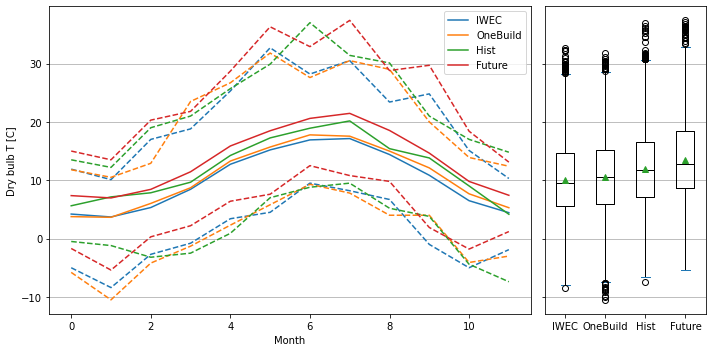

In [48]:
par = 'Dry bulb T [C]' 
# par = 'Rel Humidity [%]'
# par = 'GHI [Wh/m2]'

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, gridspec_kw={'width_ratios': [3, 1]})

axs[0].plot(iwec_AMS[par].resample('M').mean().values, color='C0', label='IWEC')
axs[0].plot(iwec_AMS[par].resample('M').min().values, color='C0', ls='--')
axs[0].plot(iwec_AMS[par].resample('M').max().values, color='C0', ls='--')

axs[0].plot(oneb_RTD[par].resample('M').mean().values, color='C1', label='OneBuild')
axs[0].plot(oneb_RTD[par].resample('M').min().values, color='C1', ls='--')
axs[0].plot(oneb_RTD[par].resample('M').max().values, color='C1', ls='--')

axs[0].plot(hist_RTD[par].resample('M').mean().values, color='C2', label='Hist')
axs[0].plot(hist_RTD[par].resample('M').min().values, color='C2', ls='--')
axs[0].plot(hist_RTD[par].resample('M').max().values, color='C2', ls='--')

axs[0].plot(futu_AMS[par].resample('M').mean().values, color='C3', label='Future')
axs[0].plot(futu_AMS[par].resample('M').min().values, color='C3', ls='--')
axs[0].plot(futu_AMS[par].resample('M').max().values, color='C3', ls='--')

axs[0].grid(axis='y')
axs[0].set_xlabel('Month')
axs[0].set_ylabel(par)
axs[0].legend()

all_par = pd.concat([iwec_AMS[par],oneb_RTD[par],hist_RTD.loc[:,par],futu_AMS[par]], axis=1)
all_par.plot(kind='box', ax=axs[1], boxprops=dict(color='k'), whiskerprops=dict(color='k'), 
             medianprops=dict(color='k'), showmeans=True)
axs[1].set_xticklabels(['IWEC','OneBuild','Hist','Future'])

axs[1].grid(axis='y')
    
plt.tight_layout()
plt.show()



Now we look closer at the summer hourly weather variables, and compare them for the months of June, July and August. Comment or uncomment the different weather files by using the sign '#'.

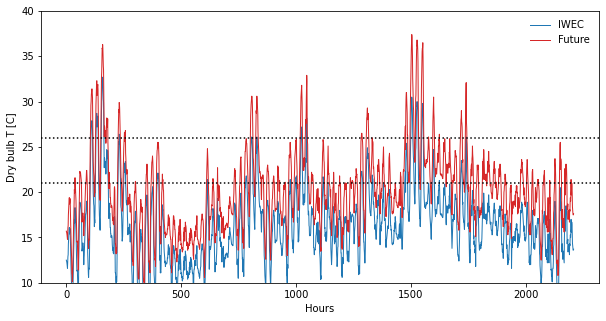

In [67]:
months = [6,7,8]

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(iwec_AMS[par][iwec_AMS.index.month.isin(months)].values, color='C0', lw=1, label='IWEC')
# ax.plot(oneb_RTD[par][iwec_AMS.index.month.isin(months)].values, color='C1', lw=1, label='OneBuild')
# ax.plot(hist_RTD[par][iwec_AMS.index.month.isin(months)].values, color='C2', lw=1, label='Hist')
ax.plot(futu_AMS[par][iwec_AMS.index.month.isin(months)].values, color='C3', lw=1, label='Future')

ax.axhline(21, color='k', ls=':')
ax.axhline(26, color='k', ls=':')

plt.ylim(10,40)
plt.xlabel('Hours')
plt.ylabel(par)

plt.legend(frameon=False)

plt.show()

# Calculate Cooling Degree Days for each weather file

We are now going to calculate the Cooling Degree Days expected for each weather file. We set a base temperature of 21$\mathrm{^o}$C, find the days for which the average temperature is above the base one, and sum the total of this difference in degrees.

In [20]:
base_temp = 21.

for n, df in zip(allweafiles.keys(), allweafiles.values()):
    diff = df['Dry bulb T [C]'].resample('D').mean() - base_temp
    cdd = diff[diff>0].sum()
    print(n)
    print('Cooling Degree Days (CDD) = %d\n' % round(cdd))

IWEC
Cooling Degree Days (CDD) = 15

OneBuild
Cooling Degree Days (CDD) = 10

Hist
Cooling Degree Days (CDD) = 43

Future
Cooling Degree Days (CDD) = 95

